## Accuracy Evaluation
---

In [1]:
import os
from constants import *

os.environ["PPLX_API_KEY"] = PPLX_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import asyncio
import json
import ast

In [3]:
example_df = pd.read_csv("climate.csv")

example_df["extraction"] = example_df["extraction"].apply(ast.literal_eval) # bodge to deal with csv storage
example_df["full_text"] = example_df['post_title'] + "\n\n" + example_df['self_text']

In [4]:
import re

def format_list(list):
    return "- " + "\n- ".join(list)

def extract_score(content):
    pattern = r"Score: \[(.*?)\]"
    match = re.search(pattern, content, re.DOTALL)
    
    if match:
        literal_list = match.group().replace("Score: ", "")
        return ast.literal_eval(literal_list)
    else: 
        raise Exception("List extraction failed!")

eval_system = """
You are a helpful assistant. Evaluate the summarized opinions and perspectives in the list compared the original text. Some opinions may require detailed reasoning to analyse. 
After analysis, please provide a final accuracy in the form of a list. The score for each item should be "Correct", "Mostly Correct", "Partially Correct", or "Incorrect".

Output Format:
Brief Reasoning: 
Score: ["Correct", "Incorrect", "Correct"]
"""
eval_template = "Original Text: \"{text}\" \n\n Summarized Opinions: \n {opinions}"

eval_prompt = ChatPromptTemplate.from_messages([("system", eval_system), ("human", eval_template)])

In [5]:
eval_llm = ChatOpenAI(temperature=0.2, model="gpt-4o")

eval_agent = eval_prompt | eval_llm

In [6]:
async def evaluate_by_row(series, eval_agent):
    t = series['full_text']
    o = format_list(series['extraction'])

    ev = eval_agent.invoke({'text': t, 'opinions': o}).content
    try:
        s = extract_score(ev)
        return ev, s
    except:
        print("Failed!")
        return(ev, [])

In [7]:
t = example_df.iloc[5]
print(t['full_text'])
print("-"*20)
print(format_list(t["extraction"]))
print("-"*20)
ev, _ = await evaluate_by_row(example_df.iloc[5], eval_agent)
print(ev)


Climate Change Is Coming for the Finer Things in Life | Wine. Olive oil. Coffee. Cocoa. ‘It does feel a little apocalyptic.’

The thing about corn is that it's mostly wind pollinated, and corn is a resilient native grass in the USA. Everything that requires pollinators will be worthless, as well as species with specific fruiting conditions.
--------------------
- Climate change will have a significant impact on the availability and quality of certain luxury items, such as wine, olive oil, coffee, and cocoa.
- The author is concerned about the potential loss of certain crops and industries due to climate change.
- Corn is highlighted as a resilient crop that is less vulnerable to climate change due to its wind-pollination method.
- The author seems to be warning about the potential extinction of species that rely on specific fruiting conditions.
--------------------
Brief Reasoning:
1. The first summarized opinion correctly captures the essence of the original text, which mentions the i

---

In [8]:
### RUN ONLY IF NECESSARY; The expensive, time consuming evaluation step.

num_samples = 200
eval_samples = example_df.sample(num_samples, random_state=42)

eval_results = await asyncio.gather(*[evaluate_by_row(row, eval_agent) for _,row in eval_samples.iterrows()])

eval_outputs, eval_scores = list(zip(*eval_results))
eval_ids = [i for i,_ in eval_samples.iterrows()]

Failed!
Failed!


In [9]:
# Optional if you want to save
with open('evals.json', 'w') as f:
   json.dump({'outputs': eval_outputs, 'scores': eval_scores, 'ids': eval_ids}, f)

---

In [9]:
# Optional if you want to load
with open('evals.json', 'r') as f:
    data = json.load(f)
    eval_scores = data['scores']
    eval_outputs = data['outputs']
    eval_ids = data["ids"]

Absolute Counts [547, 18, 40, 27]
Percentages: [86.6, 2.8, 6.3, 4.3]
Are any unaccounted for? False


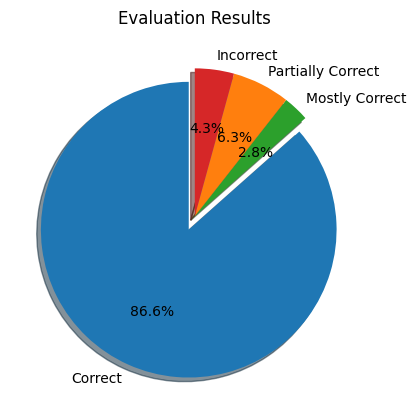

In [46]:
flat = [e for es in eval_scores for e in es]
labels = ["Correct", "Mostly Correct", "Partially Correct", "Incorrect"]

counts = [flat.count(l) for l in labels]

print("Absolute Counts", counts)
print("Percentages:", [round(c/len(flat)*100, 1) for c in counts])
print("Are any unaccounted for?", (not len(flat)-sum(counts)==0))



fig, ax = plt.subplots()
ax.pie(
    counts, 
    labels=labels, 
    explode = (0.1, 0, 0, 0),
    shadow=True,
    startangle=90,
    autopct='%1.1f%%', 
    textprops={'size': 'medium'}, 
    colors=['tab:blue', 'tab:green', 'tab:orange', 'tab:red'],
)
plt.title("Evaluation Results")
plt.show()
fig.savefig('figures/eval.png')

### Analysis
---

In [12]:
loc = ["Incorrect" in l for l in eval_scores]

for exists, id, output in zip(loc, eval_ids, eval_outputs):
    if not exists:
        continue
    
    print("#"*20)
    print(example_df['full_text'][id])
    print("-"*20)
    print(format_list(example_df['extraction'][id]))
    print("-"*20)
    print(output)


####################
UN Climate Chief Presses for Faster Action, Says Humans Have 2 Years Left 'To Save the World'

So, is there ever a point of no return? Should we always have faith? Is that rational?
--------------------
- Urgency of climate action is emphasized, with a sense of limited time.
- Skepticism towards the idea of a point of no return, questioning its rationality.
- Doubt about the feasibility of saving the world in the given timeframe.
--------------------
Brief Reasoning:
1. The original text does emphasize the urgency of climate action and mentions a limited timeframe of 2 years.
2. The original text does question the rationality of the idea of a point of no return, indicating skepticism.
3. The original text does not explicitly express doubt about the feasibility of saving the world in the given timeframe; it only mentions the urgency and the limited time.

Score: ["Correct", "Correct", "Incorrect"]
####################
The simmering volcano in Grindavik will wreak a 